In [21]:
import pandas as pd
import sqlite3
import numpy as np
import re
from tqdm import tqdm, tqdm_notebook
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import string
import time
from sklearn import svm
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
import math
import pymorphy2
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import string
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import classification_report

## fake data

In [22]:

data = pd.read_csv('fake news keywords.csv', sep='\t', index_col=False )
data = data.drop(['Unnamed: 0'], axis = 1)
indexes = data.index
data.head(4)

,Header,Content,Time,Link,Label,Topic,keywords
0,"В одном из ресторанов Нью-Йорка появится ""пяти...",Нью-йоркский ресторан Lucy's Cantina Royale бу...,6/10/2017,https://tass.ru/obschestvo/4625856,0,Политика,"пауть,острый,президент,владимир,честь,ресторан..."
1,Экс-глава МИ-6 рассказал о провальном плане за...,Бывший глава британской разведки МИ-6 Джон Ска...,15/08/2017,http://ren.tv/novosti/2017-08-15/eks-glava-mi-...,0,Политика,"россия,стратегический план,развал,план,стратег..."
2,Умерла нобелевский лауреат по литературе Светл...,Нобелевский лауреат по литературе Светлана Але...,18/05/2017,https://lenta.ru/news/2017/05/18/alex_nob/,0,Знаменитости,"еврей,жизнь,время,алексий,нобелевский,война,пр..."
3,"Путин превзошел Обаму на ГА ООН, думают 96% уч...","Большинство участников опроса, размещенного на...",0/10/2015,https://ria.ru/world/20151002/1295551989.html,0,Политика,"президент,сайт американский,сайт американский ..."


In [23]:
datafake = data[["Content", "Label"]]
#datafake = datafake[datafake['Label']!=1]
datafake.head(4)

,Content,Label
0,Нью-йоркский ресторан Lucy's Cantina Royale бу...,0
1,Бывший глава британской разведки МИ-6 Джон Ска...,0
2,Нобелевский лауреат по литературе Светлана Але...,0
3,"Большинство участников опроса, размещенного на...",0


In [24]:
stop_words = set(stopwords.words('russian'))
new_words = ['что', 'это', 'так', 'вот', 'ещё', 'свой', 'быть', 'й', 'как', 'в', 'наш', 'к', 'на', 'свой',
             'который', 'очень', 'которые', 'кстати', 'также', 'весь','риа']
stop_words = stop_words.union(new_words)
def processing(texts):
    corpus = []
    for i in tqdm_notebook(range(0, len(texts))):
        #Remove punctuations

        text = re.sub(r'\W', ' ', texts['Content'][i])
        #print(text)
        #Convert to lowercase
        text = text.lower()

        #remove tags
        text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

        # remove special characters and digits
        text=re.sub("(\\d|\\W)+"," ",text)

        ##Convert to list from string
        text = text.split()

        ## pymorphy
        analyzer = pymorphy2.MorphAnalyzer()  
        text = (analyzer.normal_forms(word)[0] for word in text)
        
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in  
                stop_words]

 
        text = " ".join(text)
        corpus.append(text)
    return corpus


def metrics(ypred, y_test):
    labels = list(set(y_test))
    for label in labels:
        print("Label: " +str(label))
        TP = sum((ypred==label)&(y_test == label))
        TP_FP = sum((ypred==label))
        Precission = round(TP/TP_FP, 3)
        print("Precission = " +str(Precission))
        TP_FN =  sum((y_test==label))
        Recall = round(TP/TP_FN, 3)
        print("Recall = " + str(Recall))
        if (Precission + Recall == 0 ):
            F = 0
        else:
            F =round( 2 * Precission * Recall / (Precission + Recall), 3)
        print("F = " + str(F)+ "\n")

Naive Bayes from sk-learn

In [25]:
def get_data(cursor, datafake, N):  
    texts = []
    sql = "SELECT Content FROM News"
    cursor.execute(sql)
    for text in cursor.fetchall():
        texts.append(text)
    content = []
    for t in texts:
        if t[0]!="":
            content.append(t[0].replace('\xa0', " "))    

    content = shuffle(content)
    content = content[:N]
    label = [2 for i in range(len(content))]
    datatrue = pd.DataFrame({'Content':content,
             'Label': label})
    Xdata = pd.concat([datatrue, datafake]).reset_index(drop = True)
    Xdata = shuffle(Xdata).reset_index(drop = True)
    #print(Xdata.head(4))
    return Xdata

def classifier(X, Y):
    count_vect = CountVectorizer()
    tfidf_transformer = TfidfTransformer()

    X = count_vect.fit_transform(X)
    X = tfidf_transformer.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X.toarray(), Y, test_size=0.35, random_state=0)

    gnb = GaussianNB()
    clf = gnb.fit(X_train, y_train)
    print("score:" ,clf.score(X_test, y_test))
    return(clf, X_test, y_test)
    

# fakes, half-fakes, truth
### hard negative, N = 500

In [63]:
conn = sqlite3.connect("hard_database.db") 
cursor = conn.cursor()
Xdata_hard = get_data(cursor, datafake, N = 500)
Xdata_hard.head(4)
Xhard = processing(Xdata_hard)
Yhard = Xdata_hard['Label']
clf,  X_test, y_test = classifier(Xhard,Yhard)
y_pred =clf.predict(X_test)
#metrics(y_pred, y_test)
report = classification_report(y_test, y_pred, target_names=['fake', 'half-fake', 'truth'])
print(report)

score: 0.7658730158730159
              precision    recall  f1-score   support

        fake       0.62      0.22      0.33        58
   half-fake       0.33      0.12      0.18         8
       truth       0.79      0.96      0.86       186

   micro avg       0.77      0.77      0.77       252
   macro avg       0.58      0.44      0.46       252
weighted avg       0.73      0.77      0.72       252



### negative , N = 500

In [27]:
conn = sqlite3.connect("negative_database.db") 
cursor = conn.cursor()

Xdata = get_data(cursor, datafake, N = 500)
Xdata.head(4)
X = processing(Xdata)
Y = Xdata['Label']
clf,  X_test, y_test = classifier(X,Y)
y_pred =clf.predict(X_test)
#metrics(y_pred, y_test)
report = classification_report(y_test, y_pred, target_names=['fake', 'half-fake', 'truth'])
print(report)


score: 0.7857142857142857
              precision    recall  f1-score   support

        fake       0.70      0.36      0.48        58
   half-fake       1.00      0.08      0.14        13
       truth       0.80      0.97      0.88       181

   micro avg       0.79      0.79      0.79       252
   macro avg       0.83      0.47      0.50       252
weighted avg       0.78      0.79      0.75       252



### hard negative N = 300

In [47]:
conn = sqlite3.connect("hard_database.db") 
cursor = conn.cursor()
Xdata_hard = get_data(cursor, datafake, N = 300)
Xdata_hard.head(4)
Xhard = processing(Xdata_hard)
Yhard = Xdata_hard['Label']
clf,  X_test, y_test = classifier(Xhard,Yhard)
y_pred =clf.predict(X_test)
#metrics(y_pred, y_test)
report = classification_report(y_test, y_pred, target_names=['fake', 'half-fake', 'truth'])
print(report)

score: 0.6373626373626373
              precision    recall  f1-score   support

        fake       0.58      0.29      0.38        63
   half-fake       0.67      0.15      0.25        13
       truth       0.65      0.91      0.76       106

   micro avg       0.64      0.64      0.64       182
   macro avg       0.63      0.45      0.46       182
weighted avg       0.63      0.64      0.59       182



### negative N = 300

In [43]:
conn = sqlite3.connect("negative_database.db") 
cursor = conn.cursor()

Xdata = get_data(cursor, datafake, N = 300)
Xdata.head(4)
X = processing(Xdata)
Y = Xdata['Label']
clf,  X_test, y_test = classifier(X,Y)
y_pred =clf.predict(X_test)
#metrics(y_pred, y_test)
report = classification_report(y_test, y_pred, target_names=['fake', 'half-fake', 'truth'])
print(report)

score: 0.6923076923076923
              precision    recall  f1-score   support

        fake       0.74      0.44      0.55        66
   half-fake       0.60      0.21      0.32        14
       truth       0.68      0.92      0.78       102

   micro avg       0.69      0.69      0.69       182
   macro avg       0.67      0.53      0.55       182
weighted avg       0.70      0.69      0.66       182



### hard negative N = 800

In [41]:
conn = sqlite3.connect("hard_database.db") 
cursor = conn.cursor()
Xdata_hard = get_data(cursor, datafake, N = 800)
Xdata_hard.head(4)
Xhard = processing(Xdata_hard)
Yhard = Xdata_hard['Label']
clf,  X_test, y_test = classifier(Xhard,Yhard)
y_pred =clf.predict(X_test)
#metrics(y_pred, y_test)
report = classification_report(y_test, y_pred, target_names=['fake', 'half-fake', 'truth'])
print(report)

score: 0.8095238095238095
              precision    recall  f1-score   support

        fake       0.67      0.16      0.26        61
   half-fake       0.00      0.00      0.00        13
       truth       0.82      0.99      0.89       283

   micro avg       0.81      0.81      0.81       357
   macro avg       0.49      0.38      0.39       357
weighted avg       0.76      0.81      0.75       357



### negative N = 800

In [48]:
conn = sqlite3.connect("negative_database.db") 
cursor = conn.cursor()

Xdata = get_data(cursor, datafake, N = 800)
Xdata.head(4)
X = processing(Xdata)
Y = Xdata['Label']
clf,  X_test, y_test = classifier(X,Y)
y_pred =clf.predict(X_test)
#metrics(y_pred, y_test)
report = classification_report(y_test, y_pred, target_names=['fake', 'half-fake', 'truth'])

print(report)

score: 0.8263305322128851
              precision    recall  f1-score   support

        fake       0.79      0.22      0.34        51
   half-fake       0.50      0.05      0.08        22
       truth       0.83      1.00      0.91       284

   micro avg       0.83      0.83      0.83       357
   macro avg       0.71      0.42      0.44       357
weighted avg       0.80      0.83      0.77       357



## F1

174


Text(0.5, 0, 'Ntrue:Nfake')

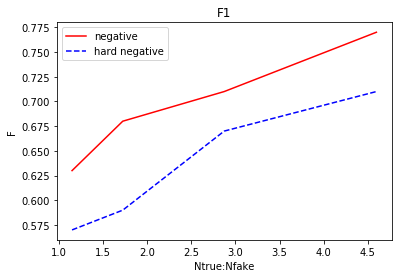

In [49]:
Nfake = len(data[data['Label']==0])
print(Nfake)
n  = np.array([200,300,500,800])

x =  n / Nfake
y_f_h = [0.57,0.59,0.67,0.71]
y_f  = [0.63,0.68,0.71,0.77]
fig, ax = plt.subplots()
ax.plot(x, y_f,color = 'red', label = "negative")
ax.plot(x, y_f_h,color = 'blue',linestyle='dashed', label = "hard negative")
ax.legend()
plt.title('F1')
ax.set_ylabel("F")

ax.set_xlabel("Ntrue:Nfake")

## Recall for Label "fake"

Text(0.5, 0, 'Ntrue:Nfake')

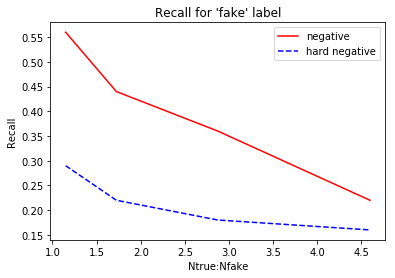

In [64]:
Nfake = len(data[data['Label']==0])
#print(Nfake)
n  = np.array([200,300,500,800])

x =  n / Nfake
y_r_h = [0.29,0.22,0.18,0.16]
y_r  = [0.56,0.44,0.36,0.22]
fig, ax = plt.subplots()
ax.plot(x, y_r,color = 'red', label = "negative")
ax.plot(x, y_r_h,color = 'blue',linestyle='dashed', label = "hard negative")
ax.legend()
plt.title("Recall for 'fake' label")
ax.set_ylabel("Recall")

ax.set_xlabel("Ntrue:Nfake")

# Fakes, truth (бинарная классификация)

In [55]:
datafake2 = data[["Content", "Label"]]
#delete half-truth
datafake2 = datafake[datafake['Label']!=1]
datafake2.head(4)

,Content,Label
0,Нью-йоркский ресторан Lucy's Cantina Royale бу...,0
1,Бывший глава британской разведки МИ-6 Джон Ска...,0
2,Нобелевский лауреат по литературе Светлана Але...,0
3,"Большинство участников опроса, размещенного на...",0


### hard negative


In [59]:
conn = sqlite3.connect("hard_database.db") 
cursor = conn.cursor()
Xdata_hard = get_data(cursor, datafake2, N = 500)
Xdata_hard.head(4)
Xhard = processing(Xdata_hard)
Yhard = Xdata_hard['Label']
clf,  X_test, y_test = classifier(Xhard,Yhard)
y_pred =clf.predict(X_test)
metrics(y_pred, y_test)
report = classification_report(y_test, y_pred, target_names=['fake', 'truth'])
print(report)

score: 0.7679324894514767
Label: 0
Precission = 0.7
Recall = 0.119
F = 0.203

Label: 2
Precission = 0.771
Recall = 0.983
F = 0.864

              precision    recall  f1-score   support

        fake       0.70      0.12      0.20        59
       truth       0.77      0.98      0.86       178

   micro avg       0.77      0.77      0.77       237
   macro avg       0.74      0.55      0.53       237
weighted avg       0.75      0.77      0.70       237



In [61]:
report = classification_report(y_test, y_pred, target_names=['fake', 'truth'], output_dict = True)
print(report)

{'fake': {'precision': 0.875, 'recall': 0.3181818181818182, 'f1-score': 0.4666666666666667, 'support': 66}, 'truth': {'precision': 0.7887323943661971, 'recall': 0.9824561403508771, 'f1-score': 0.875, 'support': 171}, 'micro avg': {'precision': 0.7974683544303798, 'recall': 0.7974683544303798, 'f1-score': 0.7974683544303798, 'support': 237}, 'macro avg': {'precision': 0.8318661971830985, 'recall': 0.6503189792663476, 'f1-score': 0.6708333333333334, 'support': 237}, 'weighted avg': {'precision': 0.8127562845426992, 'recall': 0.7974683544303798, 'f1-score': 0.7612869198312237, 'support': 237}}


## negative

In [65]:
conn = sqlite3.connect("negative_database.db") 
cursor = conn.cursor()

Xdata = get_data(cursor, datafake2, N = 500)
Xdata.head(4)
X = processing(Xdata)
Y = Xdata['Label']
clf,  X_test, y_test = classifier(X,Y)
y_pred =clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['fake',  'truth'])
print((report))

score: 0.7637130801687764
              precision    recall  f1-score   support

        fake       0.61      0.18      0.28        60
       truth       0.78      0.96      0.86       177

   micro avg       0.76      0.76      0.76       237
   macro avg       0.69      0.57      0.57       237
weighted avg       0.73      0.76      0.71       237

